# Simulation of Vessel Trajectories & Anomalies

Use the config file to adjust the number of vessels, obstacles, speed limits, ...

In [104]:
import logging
from datetime import datetime, timedelta
import json

from model import ShipModel
from agents.ship import Ship

logging.basicConfig(
    filename="notebook_logs.log",
    filemode="w",  # Overwrites on each run; use "a" to append
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)

config_file="config/config.json"
with open(config_file) as f:
    config = json.load(f)

steps = config["simulation_steps"]
    
model = ShipModel(
        width=config["width"],
        height=config["height"],
        num_ships=config["num_ships"],
        max_speed_range=config["max_speed_range"],
        speed_variation=config["speed_variation"],
        directional_variation=config["directional_variation"],
        ports=config["ports"],
        speed_limit_zones=config.get("speed_limit_zones", []),
        obstacles=config["obstacles"],
        dwa_config=config["dwa_config"],
        resolution=config["resolution"],
        obstacle_threshold=config["obstacle_threshold"],
        lookahead=config["lookahead"]
    )

for type, agents in model.agents_by_type.items():
    print(f'{type}: {len(agents)}')

for ship in model.agents.select(agent_type=Ship):
    print(f"Ship {ship.unique_id} has a maximum speed of {ship.original_max_speed}.")

<class 'agents.obstacle.Obstacle'>: 8
<class 'agents.port.Port'>: 10
<class 'agents.ship.Ship'>: 35
Ship 0 has a maximum speed of 1.3889976895475107.
Ship 1 has a maximum speed of 1.2033277821038502.
Ship 2 has a maximum speed of 1.0847479418023727.
Ship 3 has a maximum speed of 1.278223520459624.
Ship 4 has a maximum speed of 1.3444838002843609.
Ship 5 has a maximum speed of 1.4679117648322593.
Ship 6 has a maximum speed of 1.0415468550952638.
Ship 7 has a maximum speed of 1.3673488050764364.
Ship 8 has a maximum speed of 1.2704476153234476.
Ship 9 has a maximum speed of 1.0492307855303573.
Ship 10 has a maximum speed of 1.083156583864679.
Ship 11 has a maximum speed of 1.4200097597159265.
Ship 12 has a maximum speed of 1.3630892618769872.
Ship 13 has a maximum speed of 1.0683090222937293.
Ship 14 has a maximum speed of 1.0666194591486837.
Ship 15 has a maximum speed of 1.0992980948590751.
Ship 16 has a maximum speed of 1.050713558629834.
Ship 17 has a maximum speed of 1.1450910635236

## Trajectory Simulation

In [105]:
t0 = datetime.now()
print(f"{datetime.now()} Starting ...")
for t in range(steps):
    stride = 50
    if t%stride == 0:
        print(f"Steps {t} - {t+stride-1}...")
    model.step()
t1 = datetime.now()
print(f"{datetime.now()} Finished in {t1-t0}.")

2025-06-12 14:24:25.257180 Starting ...
Steps 0 - 49...
Steps 50 - 99...
Steps 100 - 149...
Steps 150 - 199...
Steps 200 - 249...
Steps 250 - 299...
Steps 300 - 349...
Steps 350 - 399...
Steps 400 - 449...
Steps 450 - 499...
Steps 500 - 549...
Steps 550 - 599...
Steps 600 - 649...
Steps 650 - 699...
Steps 700 - 749...
Steps 750 - 799...
Steps 800 - 849...
Steps 850 - 899...
Steps 900 - 949...
Steps 950 - 999...
Steps 1000 - 1049...
Steps 1050 - 1099...
Steps 1100 - 1149...
Steps 1150 - 1199...
Steps 1200 - 1249...
Steps 1250 - 1299...
Steps 1300 - 1349...
Steps 1350 - 1399...
Steps 1400 - 1449...
Steps 1450 - 1499...
2025-06-12 14:30:10.481493 Finished in 0:05:45.224313.


In [106]:
agent_df = model.datacollector.get_agent_vars_dataframe().dropna()
df = agent_df.reset_index()
df

,Step,AgentID,x,y,AStarPath
0,0,0,20.000000,80.000000,"[(20, 80), (20, 79), (20, 78), (20, 77), (20, ..."
1,0,1,45.000000,20.000000,"[(45, 20), (44, 21), (44, 22), (43, 23), (42, ..."
2,0,2,90.000000,10.000000,"[(90, 10), (89, 11), (89, 12), (89, 13), (89, ..."
3,0,3,45.000000,20.000000,"[(45, 20), (44, 21), (44, 22), (43, 23), (42, ..."
4,0,4,15.000000,45.000000,"[(15, 45), (16, 44), (17, 44), (18, 44), (19, ..."
...,...,...,...,...,...
52530,1500,27,55.000000,85.000000,"[(20, 80), (21, 80), (22, 80), (23, 81), (24, ..."
52531,1500,21,55.048229,85.226053,"[(99, 35), (98, 36), (97, 37), (96, 38), (95, ..."
52532,1500,29,20.000000,80.000000,"[(45, 20), (45, 21), (45, 22), (45, 23), (45, ..."
52533,1500,17,55.000000,85.000000,"[(45, 20), (45, 21), (45, 22), (45, 23), (45, ..."


Saved simulation plot to simulation_plot.png


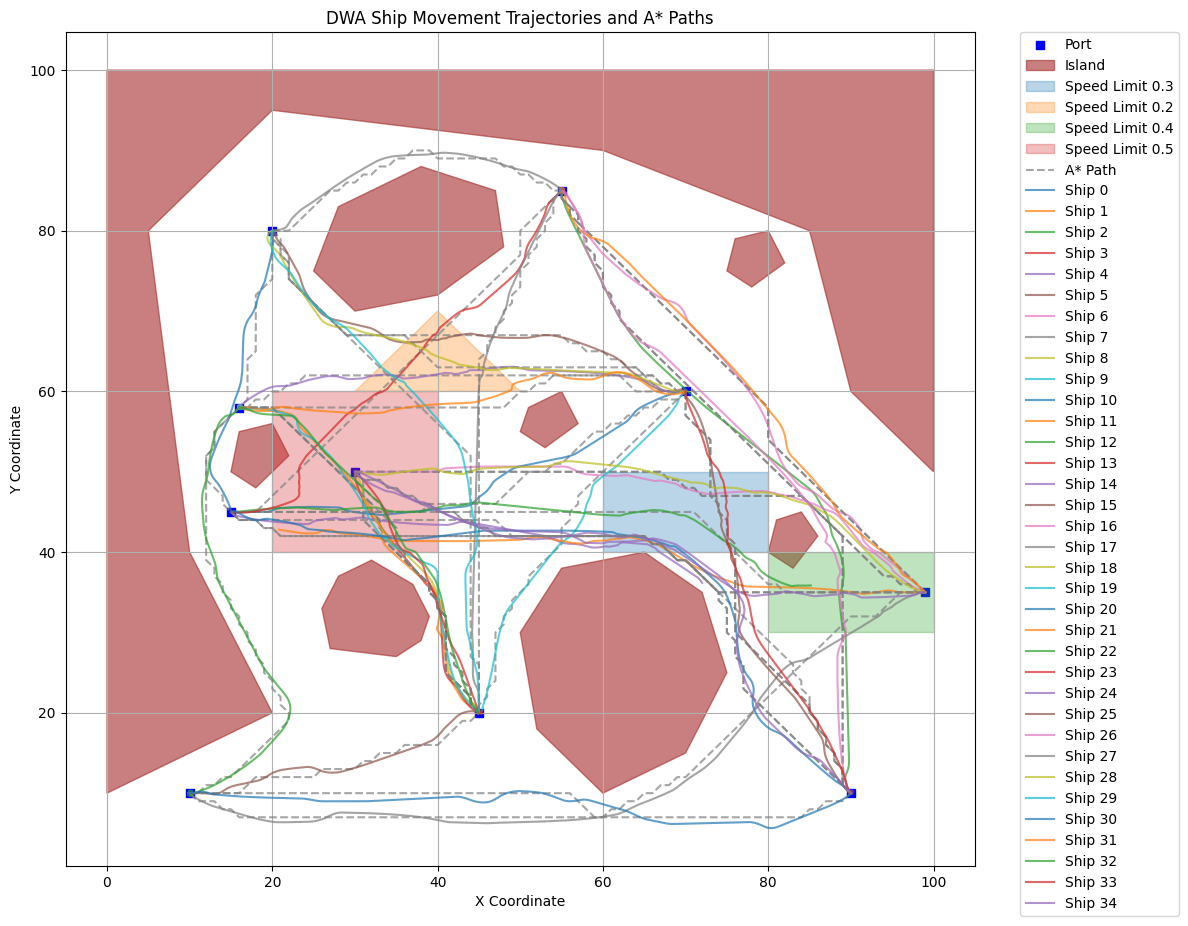

In [107]:
from visualization import plot_simulation

# Run visualization
plot_simulation(df, config)

### Transform Grid to Real-World coordinates

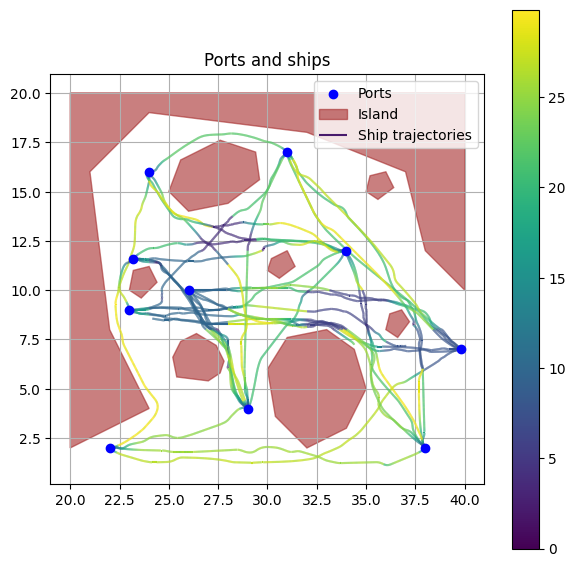

In [108]:
import movingpandas as mpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

start_datetime = datetime.now()
df = df.drop('AStarPath', axis=1)

def map_to_geocoords(x, y, bounds, width, height):
    lat = bounds["min_lat"] + (x / width) * (bounds["max_lat"] - bounds["min_lat"])
    lon = bounds["min_lon"] + (y / height) * (bounds["max_lon"] - bounds["min_lon"])
    return lat, lon

df[["x", "y"]] = df.apply(
    lambda row: map_to_geocoords(row["x"], row["y"], config["geospatial_bounds"], config["width"], config["height"]),
    axis=1, result_type="expand"
)

time_step_seconds = config["time_step_seconds"]
start_datetime = datetime.now()

df["t"] = df["Step"].apply(lambda step: start_datetime + timedelta(seconds=step * time_step_seconds))

tc = mpd.TrajectoryCollection(df, traj_id_col='AgentID', t='t', x='x', y='y', crs=31287)

fig, ax = plt.subplots(figsize=(7,7))

# Transform and plot ports
geo_ports = [map_to_geocoords(x, y, config["geospatial_bounds"], config["width"], config["height"]) for x, y in config["ports"]]
x_coords, y_coords = zip(*geo_ports)
ax.scatter(x_coords, y_coords, color='blue', label='Ports', zorder=5)

# Transform and plot obstacles
for island in config["obstacles"]:
    geo_island = [map_to_geocoords(x, y, config["geospatial_bounds"], config["width"], config["height"]) for x, y in island]
    island_shape = Polygon(geo_island)
    x, y = island_shape.exterior.xy
    ax.fill(x, y, color="brown", alpha=0.6, label="Island" if 'Island' not in plt.gca().get_legend_handles_labels()[1] else "")

tc.plot(ax=ax, label='Ship trajectories', column='speed', legend=True)
ax.grid(True)

# Labels and legend
ax.legend()
ax.set_title("Ports and ships")

plt.show()


In [98]:
import movingpandas as mpd

start_datetime = datetime.now()
df = df.drop('AStarPath', axis=1)
df["t"] = df["Step"].apply(lambda step: start_datetime + timedelta(seconds=step))
tc = mpd.TrajectoryCollection(df, traj_id_col='AgentID', t='t', x='x', y='y', crs=31287)

In [99]:
#tc = mpd.TrajectoryCollection(df, traj_id_col='AgentID', t='t', x='x', y='y', crs=31287)
tc

TrajectoryCollection with 1 trajectories

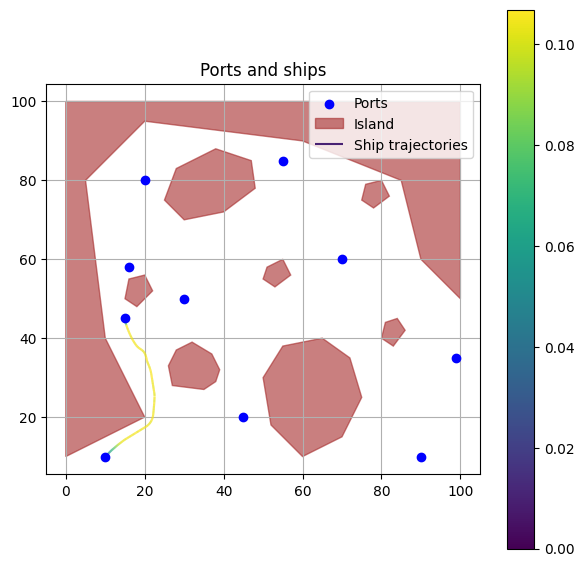

In [100]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

fig, ax = plt.subplots(figsize=(7,7))

x_coords, y_coords = zip(*config["ports"])
ax.scatter(x_coords, y_coords, color='blue', label='Ports', zorder=5)

for island in config["obstacles"]:
    island_shape = Polygon(island)
    x, y = island_shape.exterior.xy
    ax.fill(x, y, color="brown", alpha=0.6, label="Island" if 'Island' not in plt.gca().get_legend_handles_labels()[1] else "")

tc.plot(ax=ax, label='Ship trajectories', column='speed', legend=True)
ax.grid(True)

# Labels and legend
ax.legend()
ax.set_title("Ports and ships")

plt.show()

In [101]:
try:
    tc.trajectories[0].hvplot()
except:
    pass

In [109]:
import os

tc.add_speed(overwrite=True, n_threads=os.cpu_count())
tc.trajectories[0].df#.hvplot(c='speed')

,Step,AgentID,geometry,speed
t,,,,
2025-06-12 14:54:21.193373,0,0,POINT (24 16),2.0
2025-06-12 14:54:21.194373,1,0,POINT (24 15.998),2.0
2025-06-12 14:54:21.195373,2,0,POINT (24 15.996),2.2
2025-06-12 14:54:21.196373,3,0,POINT (24 15.993),2.4
2025-06-12 14:54:21.197373,4,0,POINT (24 15.991),2.6
...,...,...,...,...
2025-06-12 14:54:22.689373,1496,0,POINT (23 9),0.0
2025-06-12 14:54:22.690373,1497,0,POINT (23 9),0.0
2025-06-12 14:54:22.691373,1498,0,POINT (23 9),0.0


In [110]:
sim_result = tc.to_point_gdf()
sim_result['x'] = sim_result.geometry.x
sim_result['y'] = sim_result.geometry.y
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
sim_out_file_name = f'sim_{timestamp}.csv'
sim_result.to_csv(sim_out_file_name)
print(f'Saved simulation results to {sim_out_file_name}')
sim_result#[sim_result['speed'] > 0.6]

Saved simulation results to sim_20250612_145511.csv


,Step,AgentID,geometry,speed,x,y
t,,,,,,
2025-06-12 14:54:21.193373,0,0,POINT (24 16),2.0,24.0,16.0000
2025-06-12 14:54:21.194373,1,0,POINT (24 15.998),2.0,24.0,15.9980
2025-06-12 14:54:21.195373,2,0,POINT (24 15.996),2.2,24.0,15.9958
2025-06-12 14:54:21.196373,3,0,POINT (24 15.993),2.4,24.0,15.9934
2025-06-12 14:54:21.197373,4,0,POINT (24 15.991),2.6,24.0,15.9908
...,...,...,...,...,...,...
2025-06-12 14:54:22.689373,1496,34,POINT (26 10),0.0,26.0,10.0000
2025-06-12 14:54:22.690373,1497,34,POINT (26 10),0.0,26.0,10.0000
2025-06-12 14:54:22.691373,1498,34,POINT (26 10),0.0,26.0,10.0000


## Anomaly Simulation

In [24]:
import numpy as np
import pandas as pd
import movingpandas as mpd
from datetime import datetime, timedelta

In [25]:
sim_out_file_name = 'sim_20250610_125111.csv'
PERCENTAGE_OF_ANOMALIES = 0.03

In [112]:
sims = pd.read_csv(sim_out_file_name)
sims

NameError: name 'pd' is not defined

In [ ]:
#sims = sims[sims.AgentID<29].copy()
sims['is_anomaly'] = False
sims['anomaly_type'] = 'n/a'


In [113]:
tc = mpd.TrajectoryCollection(sims, t='t', traj_id_col='AgentID', x='x', y='y', crs=31287)
tc

NameError: name 'sims' is not defined

In [ ]:
# Remove stopped segments (with speed < 0.0001)
tc = mpd.SpeedSplitter(tc).split(speed=0.0001, duration=timedelta(seconds=5))
tc

### Speed

Change the timestamps to make a subsection of the trajectory faster

In [ ]:
unique_ids = sims.AgentID.unique()
unique_ids

In [ ]:
sample_ids_pd = pd.Series(unique_ids).sample(frac=PERCENTAGE_OF_ANOMALIES).tolist()
print("Subset we'll insert anomalies in: ", sample_ids_pd)

In [ ]:
def inject_speed_anomaly(traj, duration_pct=(0.1,0.2), speedup_pct=(1.5,2.5)):
    df = traj.df.copy()
    df.reset_index(inplace=True)
    df["t_diff"] = df['t'].diff()
    # Choose within middle range
    total_steps = len(df)
    anomaly_start_idx = np.random.randint(0.1 * total_steps, 0.8 * total_steps)  
    duration_pct = duration_pct[0] + (np.random.random() * (duration_pct[1]-duration_pct[0]))
    anomaly_duration = int(duration_pct * total_steps)  
    # Insert new values
    speedup_pct = speedup_pct[0] + (np.random.random() * (speedup_pct[1]-speedup_pct[0]))
    new_vals = df.iloc[anomaly_start_idx : anomaly_start_idx + anomaly_duration].t_diff / speedup_pct
    df.loc[anomaly_start_idx : anomaly_start_idx + anomaly_duration -1, "t_diff"] = new_vals
    # Flag anomalies
    df.loc[anomaly_start_idx : anomaly_start_idx + anomaly_duration -1, "is_anomaly"] = True
    df.loc[anomaly_start_idx : anomaly_start_idx + anomaly_duration -1, "anomaly_type"] = 'speed'

    # Correct the timestamp update logic
    df["t"] = df["t"].iloc[0] + df["t_diff"].fillna(pd.Timedelta(seconds=0)).cumsum()
    return mpd.Trajectory(df,t='t',traj_id=traj.id)

In [ ]:
for i, traj in enumerate(tc.trajectories):
    if i in sample_ids_pd: 
        traj = inject_speed_anomaly(traj)
        tc.trajectories[i] = traj
    
tc.add_speed(overwrite=True)
tc.plot(column='speed', legend=True)

In [ ]:
ax = tc.plot(column='is_anomaly', cmap='Accent')

In [ ]:
try:
    tc.trajectories[0].hvplot(c='speed')
except:
    pass

In [ ]:
sim_result = tc.to_point_gdf()
sim_result['x'] = sim_result.geometry.x
sim_result['y'] = sim_result.geometry.y
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
sim_out_file_name = f'anomalies_speed_{timestamp}.csv'
sim_result.to_csv(sim_out_file_name)
print(f'Saved simulated speed anomalies to {sim_out_file_name}')

### Location

#### Generate trajectories that pass through obstacles

Note that is not guaranteed that each resulting trajectory will pass through an obtacle! Ships simply ignore the obstacles.

In [ ]:
import logging
from datetime import datetime, timedelta
import json

from model import ShipModel
from agents.ship import Ship

logging.basicConfig(
    filename="notebook_logs.log",
    filemode="w",  # Overwrites on each run; use "a" to append
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)

config_file="config/config.json"
with open(config_file) as f:
    config = json.load(f)

steps = config["simulation_steps"]
    
model = ShipModel(
        width=config["width"],
        height=config["height"],
        num_ships=int(config["num_ships"]*2*PERCENTAGE_OF_ANOMALIES), # doubling the number, assuming that 50% will violate obstacles
        max_speed_range=config["max_speed_range"],
        ports=config["ports"],
        speed_limit_zones=config.get("speed_limit_zones", []),
        obstacles=[config["obstacles"][0]], # Here we only select the first obstacle that describes the main land mass
        dwa_config=config["dwa_config"],
        resolution=config["resolution"],
        obstacle_threshold=config["obstacle_threshold"],
        lookahead=config["lookahead"]
    )

In [ ]:
print(f"{datetime.now()} Starting ...")
for t in range(steps):
    stride = 50
    if t%stride == 0:
        print(f"Steps {t} - {t+stride-1}...")
    model.step()
print(f"{datetime.now()} Finished.")

In [ ]:
agent_df = model.datacollector.get_agent_vars_dataframe().dropna()
df = agent_df.reset_index()
df

In [ ]:
from visualization import plot_simulation
plot_simulation(df, config)

In [ ]:
import movingpandas as mpd

start_datetime = datetime.now()
df = df.drop('AStarPath', axis=1)
df["t"] = df["Step"].apply(lambda step: start_datetime + timedelta(seconds=step))
tc = mpd.TrajectoryCollection(df, traj_id_col='AgentID', t='t', x='x', y='y', crs=31287)

In [ ]:
tc.add_speed(overwrite=True)
tc.trajectories[0].df

In [ ]:
sim_result = tc.to_point_gdf()
sim_result['x'] = sim_result.geometry.x
sim_result['y'] = sim_result.geometry.y
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
sim_out_file_name = f'sim_no-obstacles_{timestamp}.csv'
sim_result.to_csv(sim_out_file_name)
print(f'Saved simulation results to {sim_out_file_name}')

#### Flag anomalies

In [ ]:
sims = pd.read_csv(sim_out_file_name)
sims

In [ ]:
#sims = sims[sims.AgentID<22].copy()
sims['is_anomaly'] = False
sims['anomaly_type'] = 'n/a'
tc = mpd.TrajectoryCollection(sims, t='t', traj_id_col='AgentID', x='x', y='y', crs=31287)
tc

In [ ]:
tc.plot()

In [ ]:
from shapely.geometry import Polygon
from geopandas import GeoSeries

def inject_location_anomaly(traj, polygon):
    df = traj.df.copy()
    intersecting = df.intersects(polygon)
    df.loc[intersecting, 'is_anomaly'] = True
    df.loc[intersecting, 'anomaly_type'] = 'location'
    return mpd.Trajectory(df,t='t',traj_id=traj.id)

In [ ]:

obstacles=config["obstacles"]
polygons=[]

for obstacle in obstacles:
    polygon = Polygon(obstacle)
    polygons.append(polygon)
    for i, traj in enumerate(tc.trajectories):
        traj = inject_location_anomaly(traj, polygon)
        tc.trajectories[i] = traj
    

In [ ]:
ax = tc.plot(column='is_anomaly', cmap='Accent')
GeoSeries(polygons).plot(ax=ax, color="lightgray")

In [ ]:
sim_result = tc.to_point_gdf()
sim_result['x'] = sim_result.geometry.x
sim_result['y'] = sim_result.geometry.y
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
sim_out_file_name = f'anomalies_loc_{timestamp}.csv'
sim_result.to_csv(sim_out_file_name)
print(f'Saved simulated location anomalies to {sim_out_file_name}')

### Direction

TODO

## Merge files

In [ ]:
df1 = pd.read_csv("anomalies_speed_20250517_172830.csv")
df2 = pd.read_csv("anomalies_loc_20250517_184842.csv")
out = pd.concat([df1,df2])[['t','AgentID','speed','is_anomaly','anomaly_type','x','y']]
out.to_csv("synthetic_vessel_tracks_with_anomalies_20250517.csv", index=False)

In [ ]:
tmp = pd.read_csv("synthetic_vessel_tracks_with_anomalies_20250517.csv")
tmp

In [ ]:
tmp[tmp.anomaly_type=="location"]

In [ ]:
tmp[tmp.anomaly_type=="location"].AgentID.unique()